In [16]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


- https://keras.io/examples/vision/image_classification_from_scratch/
- 보행도로(운행불가능)와 자전거도로, 차도(운행가능)으로 나누어 학습

In [17]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Dataset 생성

In [18]:
image_size = (180, 180)
batch_size = 128

train_ds = tf.keras.utils.image_dataset_from_directory(
    "/content/drive/MyDrive/CNN_Road/CNN_doro",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 800 files belonging to 2 classes.
Using 640 files for training.


In [19]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    "/content/drive/MyDrive/CNN_Road/CNN_doro",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 800 files belonging to 2 classes.
Using 160 files for validation.


# Data의 시각화

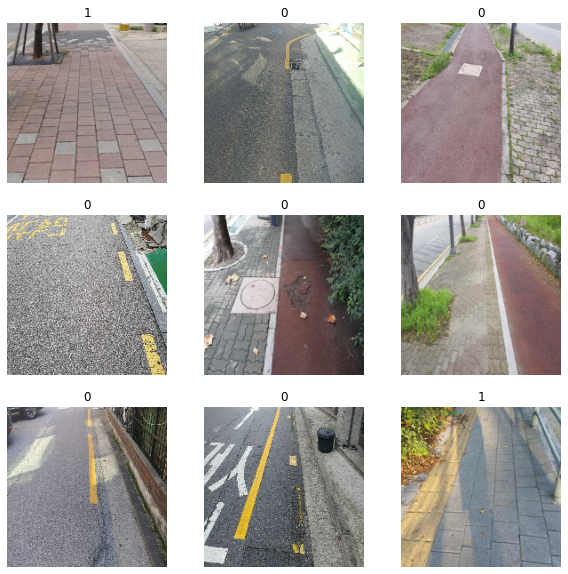

In [20]:
import matplotlib.pyplot as plt

#1: 운행불가능, 0: 운행가능

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

# 이미지 데이터 증강 사용

In [21]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)

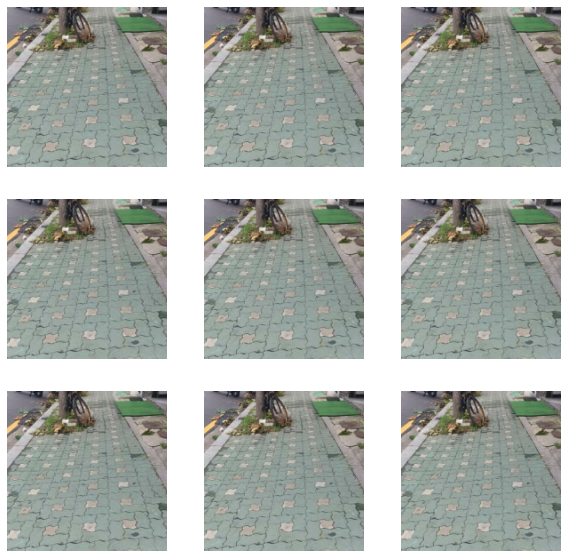

In [22]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

# 증강 이미지

In [23]:
#옵션 2 사용
augmented_train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y))

# 성능을 위한 데이터 세트 구성

In [24]:
# Apply `data_augmentation` to the training images.
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf.data.AUTOTUNE,
)
# Prefetching samples in GPU memory helps maximize GPU utilization.
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

In [13]:
# 모델 구축

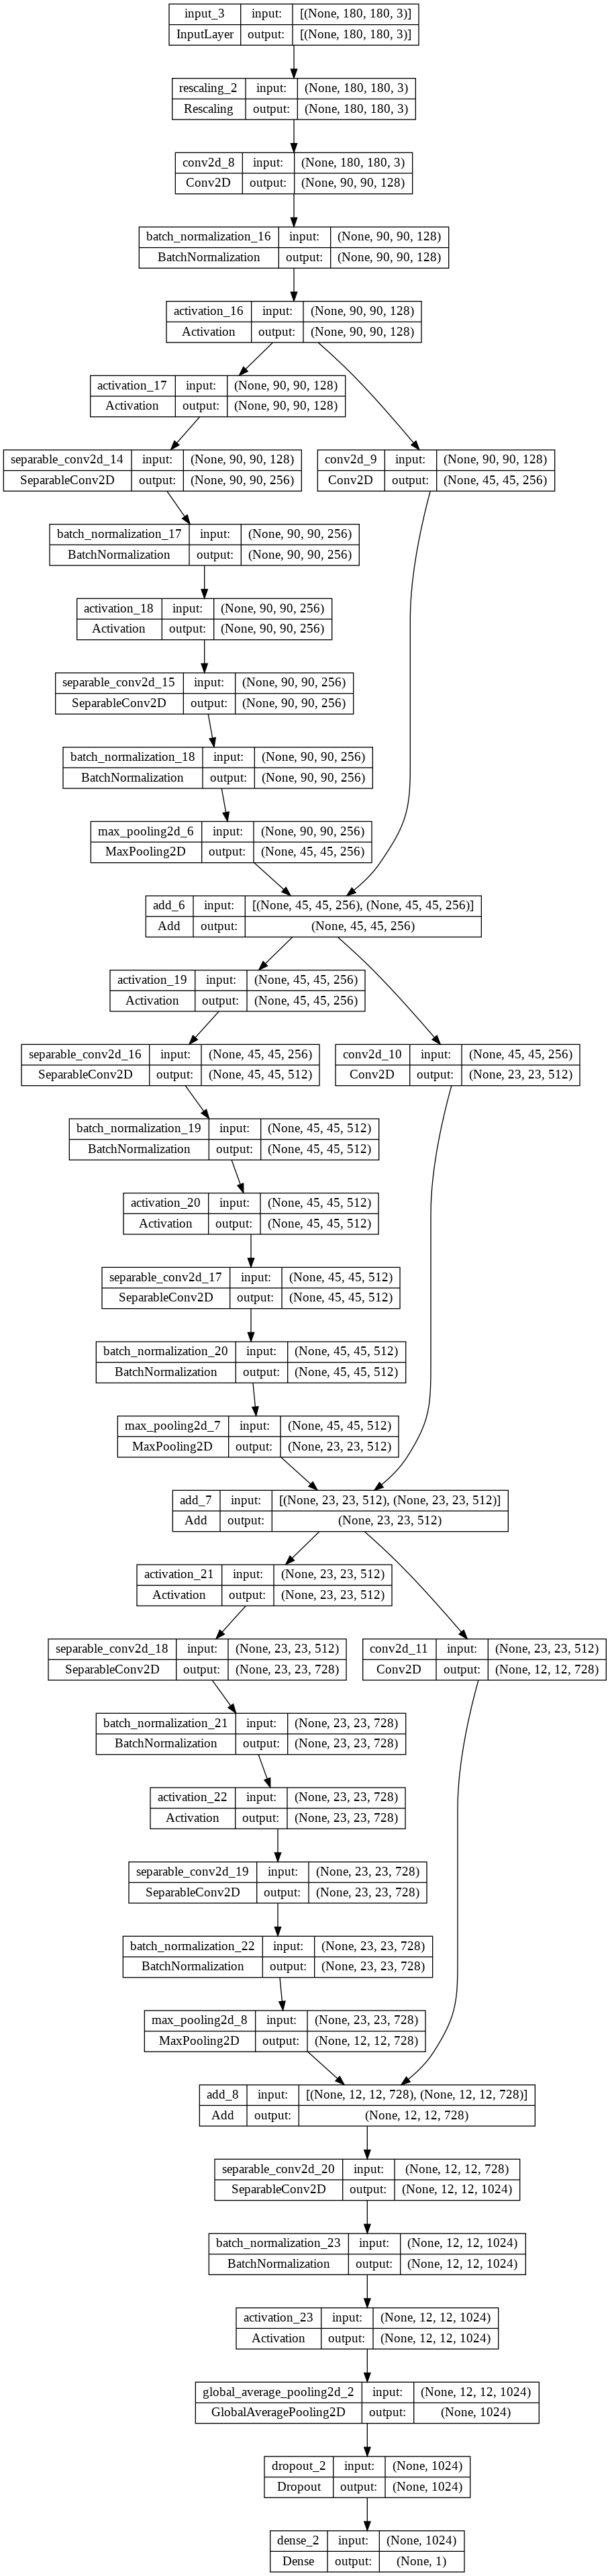

In [25]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

# 모델 학습

In [29]:
epochs = 25

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
history=model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)

Epoch 1/25
5/5 [==============================] - 62s 10s/step - loss: 0.5915 - accuracy: 0.6953 - val_loss: 0.6939 - val_accuracy: 0.4563
Epoch 2/25
5/5 [==============================] - 13s 2s/step - loss: 0.2752 - accuracy: 0.8891 - val_loss: 0.6934 - val_accuracy: 0.4563
Epoch 3/25
5/5 [==============================] - 13s 2s/step - loss: 0.1328 - accuracy: 0.9484 - val_loss: 0.6932 - val_accuracy: 0.4563
Epoch 4/25
5/5 [==============================] - 13s 2s/step - loss: 0.0821 - accuracy: 0.9719 - val_loss: 0.6903 - val_accuracy: 0.5688
Epoch 5/25
5/5 [==============================] - 13s 2s/step - loss: 0.1240 - accuracy: 0.9609 - val_loss: 0.6905 - val_accuracy: 0.5625
Epoch 6/25
5/5 [==============================] - 13s 2s/step - loss: 0.0518 - accuracy: 0.9859 - val_loss: 0.6902 - val_accuracy: 0.5688
Epoch 7/25
5/5 [==============================] - 13s 2s/step - loss: 0.0499 - accuracy: 0.9797 - val_loss: 0.6905 - val_accuracy: 0.6313
Epoch 8/25
5/5 [=================

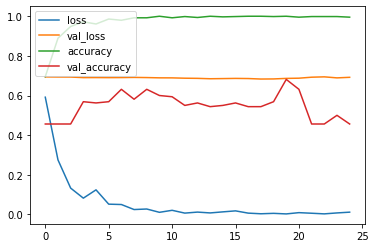

In [30]:
plot_target = ['loss', 'val_loss', 'accuracy', 'val_accuracy']
for each in plot_target:
    plt.plot(history.history[each], label=each)
    
plt.legend()
plt.show()

In [31]:
from helper_function import plot_loss_curves
plot_loss_curves(history)

ModuleNotFoundError: ignored

# 새 데이터에 대한 추론 실행

In [32]:
img = keras.preprocessing.image.load_img(
    "/content/drive/MyDrive/도로이미지/보행도로/ped_100.png", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = float(predictions[0])
print(f"This image is {100 * (1 - score):.2f}% 가능 and {100 * score:.2f}% 불가능.")

1/1 [==============================] - 0s 466ms/step
This image is 54.55% 가능 and 45.45% 불가능.


In [33]:
img = keras.preprocessing.image.load_img(
    "/content/drive/MyDrive/도로이미지/자전거도로/bikeroad_12.png", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = float(predictions[0])
print(f"This image is {100 * (1 - score):.2f}% 가능 and {100 * score:.2f}% 불가능.")

1/1 [==============================] - 0s 16ms/step
This image is 54.42% 가능 and 45.58% 불가능.


In [34]:
model.save('CNN_Road.h5')

In [35]:
score = float(predictions[0])

In [36]:
predictions

array([[0.45575458]], dtype=float32)